In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import glob
import re
import cartopy.crs as ccrs  # Correct import for coordinate reference systems
import cartopy.feature as cfeature

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [34]:
# Boulder Lat Lon
boulder_lat = 40.014
boulder_lon = -105.270 + 360
#
# Bounding box for Colorado
colorado_right  =  (-109.060253 + 360)%360
colorado_left   = (-102.041524 + 360)%360 
colorado_bottom = 37
colorado_top    = 41

In [4]:
# File paths
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_data    = '/gpfs/csfs1/collections/rda/data/'
era5_path   = rda_data + 'ds633.0/e5.oper.an.sfc/'
zarr_path   = rda_scratch + '/tas_zarr/'

In [5]:
# #Pelican test path
# pelican_test = '/glade/campaign/collections/rda/transfer/harshah/pelican_test'
# zarr_path   = rda_scratch + '/tas_zarr/'

In [6]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '2:30:00',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/work/harshah/conda-envs/zarr_experiments/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38201 instead
  warnings.warn(


In [7]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38201/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38201/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.119:41373,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38201/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
cluster.scale(2)

In [9]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38201/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.119:41373,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38201/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Compute JJA anomaly for 1994-2023 w.r.t 1940-1969 for a lat-lon grid which bounds Colorado

In [10]:
%%time
tas_monthly_zarr      = xr.open_zarr(zarr_path +'e5_tas2m_monthly_1940_2023.zarr').VAR_2T
tas_monthly_zarr

CPU times: user 231 ms, sys: 62.3 ms, total: 293 ms
Wall time: 1.3 s


<xarray.DataArray 'VAR_2T' (time: 1009, latitude: 721, longitude: 1440)> Size: 4GB
dask.array<open_dataset-VAR_2T, shape=(1009, 721, 1440), dtype=float32, chunksize=(1000, 721, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 8kB 1940-01-31 1940-02-29 ... 2024-01-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [11]:
tas_monthly_zarr      = tas_monthly_zarr.sel(latitude=slice(colorado_top,colorado_bottom),\
                                         longitude=slice(colorado_right,colorado_left))
tas_monthly_zarr 

<xarray.DataArray 'VAR_2T' (time: 1009, latitude: 17, longitude: 28)> Size: 2MB
dask.array<getitem, shape=(1009, 17, 28), dtype=float32, chunksize=(1000, 17, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 136B 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude  (longitude) float64 224B 251.0 251.2 251.5 ... 257.2 257.5 257.8
  * time       (time) datetime64[ns] 8kB 1940-01-31 1940-02-29 ... 2024-01-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [12]:
%%time
tas_monthly_nc  = xr.open_mfdataset(zarr_path +'e5_tas2m_monthly_1940_2023.nc',engine='netcdf4',chunks='auto').VAR_2T
tas_monthly_nc  = tas_monthly_nc.sel(latitude=slice(colorado_top,colorado_bottom),\
                                         longitude=slice(colorado_right,colorado_left))
tas_monthly_nc

CPU times: user 27.6 ms, sys: 6.76 ms, total: 34.4 ms
Wall time: 369 ms


<xarray.DataArray 'VAR_2T' (time: 1009, latitude: 17, longitude: 28)> Size: 2MB
dask.array<getitem, shape=(1009, 17, 28), dtype=float32, chunksize=(320, 17, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 136B 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude  (longitude) float64 224B 251.0 251.2 251.5 ... 257.2 257.5 257.8
  * time       (time) datetime64[ns] 8kB 1940-01-31 1940-02-29 ... 2024-01-31
Attributes: (12/14)
    maximum_value:                                      320.42938232421875
    long_name:                                          2 metre temperature
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    short_name:                                         2t
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    minimum_value:                                      216.13075256347656
    ...                                                 ...
    original_format:                                    WMO GRIB 1 with ECMWF...
    units:                                              K
    rda_dataset_group:                                  ERA5 atmospheric surf...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    ecmwf_local_table:                                  128

#### Now compute monthly anomaly for JJA and comapre zarr vs netcdf

In [13]:
months = [6,7,8]

In [14]:
%%time
jja_tas_zarr = tas_monthly_zarr.sel(time=tas_monthly_zarr['time'].dt.month.isin(months))
jja_tas_nc   = tas_monthly_nc.sel(time=tas_monthly_nc['time'].dt.month.isin(months))

CPU times: user 6.32 ms, sys: 3.47 ms, total: 9.79 ms
Wall time: 9.8 ms


In [15]:
%%time
baseline_period = np.arange(1940,1970)
current_period  = np.arange(1994,2024)
#
jja_baseline_zarr = jja_tas_zarr.sel(time = jja_tas_zarr['time'].dt.year.isin(baseline_period))
jja_current_zarr  = jja_tas_zarr.sel(time = jja_tas_zarr['time'].dt.year.isin(current_period))
#
jja_baseline_nc   = jja_tas_nc.sel(time = jja_tas_nc['time'].dt.year.isin(baseline_period))
jja_current_nc    = jja_tas_nc.sel(time = jja_tas_nc['time'].dt.year.isin(current_period))

CPU times: user 8.12 ms, sys: 0 ns, total: 8.12 ms
Wall time: 8.14 ms


In [16]:
#
jja_anomaly_zarr   = jja_current_zarr.mean('time') - jja_baseline_zarr.mean('time')
jja_anomaly_nc     = jja_current_nc.mean('time') - jja_baseline_nc.mean('time')
jja_anomaly_nc

<xarray.DataArray 'VAR_2T' (latitude: 17, longitude: 28)> Size: 2kB
dask.array<sub, shape=(17, 28), dtype=float32, chunksize=(17, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 136B 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude  (longitude) float64 224B 251.0 251.2 251.5 ... 257.2 257.5 257.8

In [17]:
# %%time
# ## Generate performance report
# with performance_report(filename ='zarr_jja_anomaly.html'):
#      jja_anomaly_zarr.to_dataset().to_zarr(zarr_path + 'e5_jja_anomaly.zarr',mode='w')

CPU times: user 532 ms, sys: 261 ms, total: 793 ms
Wall time: 9.9 s


In [18]:
# %%time
# ## Generate performance report
# with performance_report(filename ='nc_jja_anomaly.html'):
#      jja_anomaly_nc.to_dataset().to_netcdf(zarr_path + 'e5_jja_anomaly.nc',mode='w')

CPU times: user 419 ms, sys: 41.6 ms, total: 461 ms
Wall time: 6.55 s


## Plotting

In [19]:
%%time
jja_anomaly_zarr = xr.open_zarr(zarr_path + 'e5_jja_anomaly.zarr').VAR_2T
jja_anomaly_nc   = xr.open_mfdataset(zarr_path + 'e5_jja_anomaly.nc').VAR_2T

CPU times: user 6.4 ms, sys: 2.5 ms, total: 8.89 ms
Wall time: 11.8 ms


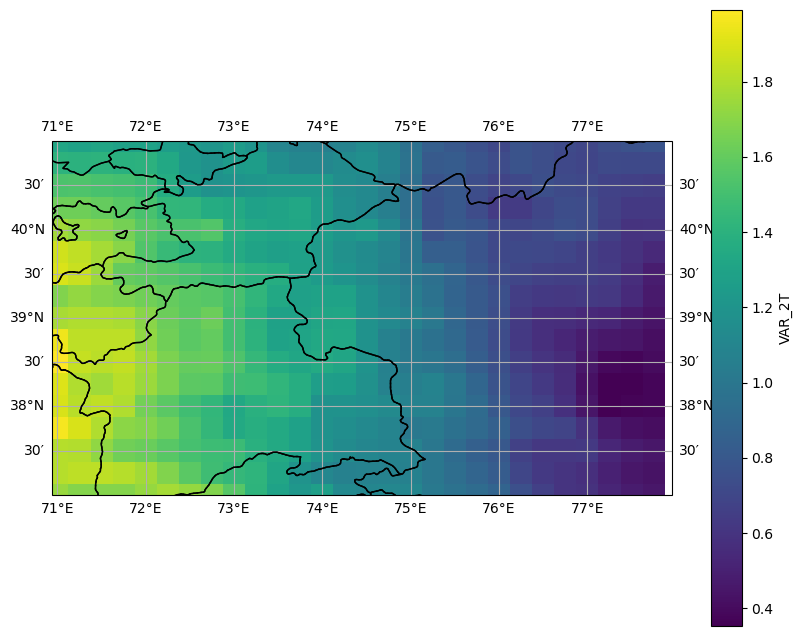

In [50]:
# Create a plot with a geographic projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  # Using the Plate Carree projection

colorado_extent = [251, 258, 37, 41] 

# Set the extent to focus tightly on Colorado
ax.set_extent([colorado_right, colorado_left, colorado_bottom, colorado_top], crs=ccrs.PlateCarree(central_longitude=180))


# Add state borders, but only for Colorado
states = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')

ax.add_feature(states, edgecolor='black')  # Add only state borders
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', zorder=3)

# Plot the data
jja_anomaly_zarr.plot(ax=ax, transform=ccrs.PlateCarree(central_longitude=180),
        x='longitude', y='latitude',
        cmap='viridis',  # Choose a colormap that suits your data
        add_colorbar=True)  # Optionally add a colorbar

#
# Add gridlines and labels 
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Display the plot
plt.show()

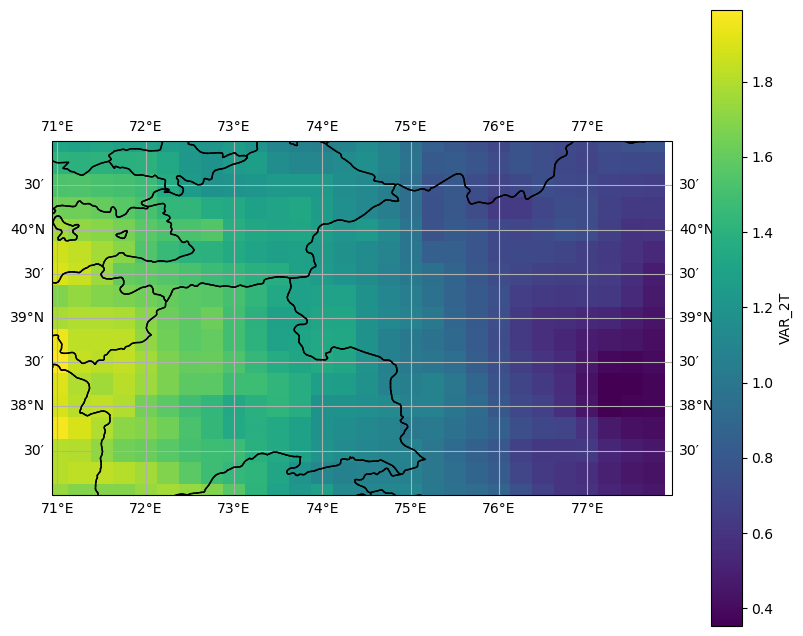

In [48]:
# Create a plot with a geographic projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  # Using the Plate Carree projection

# Set the extent to focus tightly on Colorado
ax.set_extent([colorado_right, colorado_left, colorado_bottom, colorado_top], crs=ccrs.PlateCarree(central_longitude=180))

# Add state borders, but only for Colorado
states = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')

ax.add_feature(states, edgecolor='black')  # Add only state borders

# Plot the data
jja_anomaly_nc.plot(ax=ax, transform=ccrs.PlateCarree(central_longitude=180),
        x='longitude', y='latitude',
        cmap='viridis',  # Choose a colormap that suits your data
        add_colorbar=True)  # Optionally add a colorbar

ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', zorder=3)

#
# Add gridlines and labels 
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Display the plot
plt.show()